<a href="https://colab.research.google.com/github/adityanandy2802/ml-dl-task/blob/main/SRIP_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Information about our data set: 
* A data set of foxes and dogs were created each of which have approximately 1.3K images for each class. Dataset was collected from [this site](https://images.cv/).
* We use RESNET50 for our classification problem

We first extract our data from the zip file.

In [ ]:
from zipfile import ZipFile
with ZipFile("/content/dog vs fox categorical.zip", 'r') as zip:
  zip.extractall()

In [ ]:
dir_path="/content/dog vs fox categorical/train"

Import our libraries

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import os
import PIL
import cv2
import numpy as np

We read the images from out dataset using `tf.keras.utils.image_dataset_from_directory` method. 
* We set an image size. This will standardise all the images in the dataset (which have random shapes) into one standardised shape.
* We divide the data into batches of 32
* We also have a validation split = 0.2

In [ ]:
image_height, image_width=256,256
batch_size=32
train_ds=tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset="training",
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(image_height,image_width),
    seed=123,
    validation_split=0.2,
)

Found 2599 files belonging to 2 classes.
Using 2080 files for training.


In [ ]:
val_ds=tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset="validation",
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(image_height,image_width),
    seed=123,
    validation_split=0.2,
)

Found 2599 files belonging to 2 classes.
Using 519 files for validation.


We print the class names: `dog` and `fox`

In [ ]:
class_names=train_ds.class_names
class_names

['dog', 'fox']

We take a Sequential model.

In [ ]:
resnet=Sequential()

`tf.keras.applications` has many pretrained models whose weights can be used to make our own models. Here we use `ResNet50`

** We set layer in `pretrained_model.layers` = `False` because we dont want the model to change its weights based on our dataset.

In [ ]:
pretrained_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_height, image_width, 3),
    pooling='max',
    classes=2,
)

for layer in pretrained_model.layers:
  layer.trainable=False

94765736/94765736 [==============================] - 0s 0us/step


Pretrained model is added to our model

In [ ]:
resnet.add(pretrained_model)

* We add `Flatten` layer to flatten the outpur into a single array.
* A `Dense` layer with `relu` activation to evaluate the output of the `Flatten` layer.
* Another `Dense` layer to classify into 2 classes

In [ ]:
resnet.add(Flatten())
resnet.add(Dense(512, 'relu'))
resnet.add(Dense(2, 'softmax'))

We compile our Model using `Adam` optimizer:
* Learning rate: `0.001`
* Loss function: `Binary Cross Entropy`
* Metrics: `Accuracy`


In [ ]:
resnet.compile(optimizer=Adam(lr=1e-3),loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


We train our model for 10 epochs 

In [ ]:
epochs=10
history=resnet.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs)

Epoch 1/10
65/65 [==============================] - 25s 218ms/step - loss: 1.3645 - accuracy: 0.9207 - val_loss: 0.0808 - val_accuracy: 0.9827
Epoch 2/10
65/65 [==============================] - 10s 156ms/step - loss: 0.0599 - accuracy: 0.9889 - val_loss: 0.0735 - val_accuracy: 0.9884
Epoch 3/10
65/65 [==============================] - 10s 155ms/step - loss: 0.0166 - accuracy: 0.9971 - val_loss: 0.0904 - val_accuracy: 0.9846
Epoch 4/10
65/65 [==============================] - 10s 155ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0933 - val_accuracy: 0.9846
Epoch 5/10
65/65 [==============================] - 10s 157ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0674 - val_accuracy: 0.9904
Epoch 6/10
65/65 [==============================] - 11s 164ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9904
Epoch 7/10
65/65 [==============================] - 11s 166ms/step - loss: 2.9132e-04 - accuracy: 1.0000 - val_loss: 0.0607 - val_accuracy: 0.

Plot between `accuracy` and `val_accuracy`

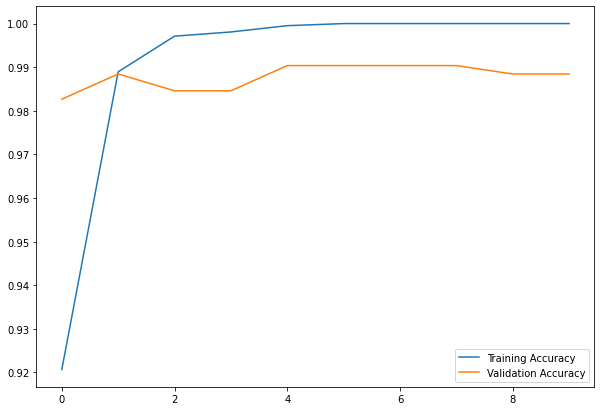

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

Plot between `loss` and `val_loss`

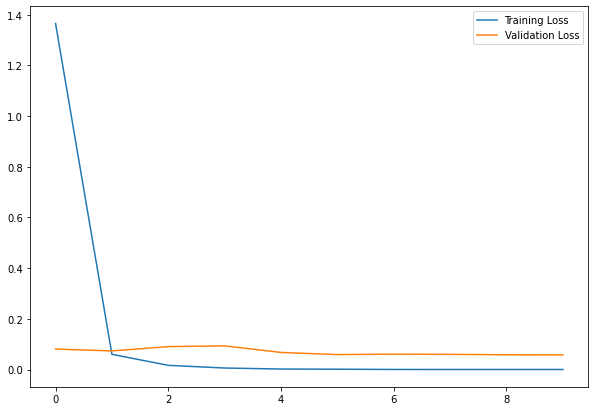

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Testing

We will now choose 2 pictures randomly out of our test dataset and see if our model predicts the classes accurately

In [ ]:
test_dir="/content/dog vs fox categorical/test"

We choose 2 images randomly
* Image1 is a pic of a fox
* Image 2 is a pic of a dog

In [ ]:
test_list=os.listdir(test_dir)
image1=test_list[29]
image1_path=test_dir+"/"+image1
image2=test_list[6]
image2_path=test_dir+"/"+image2

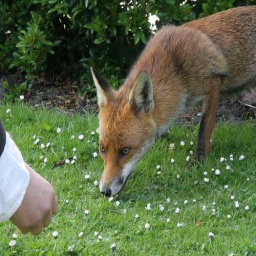

In [ ]:
PIL.Image.open(str(image1_path))

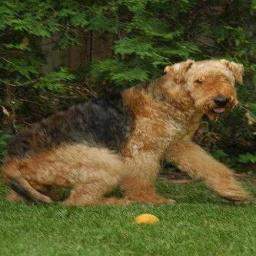

In [ ]:
PIL.Image.open(str(image2_path))

It is necessary to expand the dimensions to 4 to feed the image into the model, hence, we do this step.

In [ ]:
dog=cv2.imread(image2_path)
dog=np.expand_dims(dog, axis=0)
fox=cv2.imread(image1_path)
fox=np.expand_dims(fox, axis=0)

It predicts our images accurately

In [ ]:
class_names[np.argmax(resnet.predict(dog))]

1/1 [==============================] - 1s 1s/step


'dog'

In [ ]:
class_names[np.argmax(resnet.predict(fox))]

1/1 [==============================] - 0s 27ms/step


'fox'